In [20]:
import yfinance as yf
import pandas as pd
import numpy as np
import networkx as nx

# df = yf.download('^RUA')
# df

<AxesSubplot:xlabel='Date'>

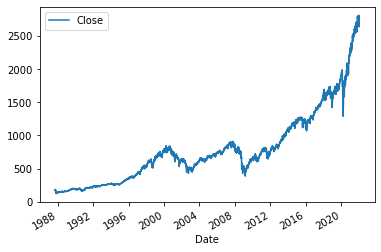

In [4]:
df[['Close']].plot()

In [5]:
# import pandasdatareader as web
# df = web.DataReader('^IXIC', data_source = 'yahoo', start = '2000-01-01')
df = yf.download('^RUA',start = '2000-01-01')
df.reset_index(inplace = True) #resetting index
df.head() # display

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,793.309998,798.419983,776.400024,786.200012,786.200012,0
1,2000-01-04,786.270020,786.270020,754.739990,755.799988,755.799988,0
2,2000-01-05,755.799988,762.210022,742.820007,757.090027,757.090027,0
3,2000-01-06,757.090027,761.960022,751.590027,756.729980,756.729980,0
4,2000-01-07,756.729980,777.250000,755.460022,777.250000,777.250000,0


In [6]:
data = df[['High','Low','Open','Adj Close']]
data['pct_ret'] = data['Adj Close'].pct_change()
data.tail()
data['state'] = data['pct_ret'].apply(lambda x: 'up' if (x > 0.001)\
else ('down' if (x < -0.001)\
else 'no_change'))
data.tail()

C:\Users\lemon\AppData\Local\Temp/ipykernel_16472/3093553083.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['pct_ret'] = data['Adj Close'].pct_change()
C:\Users\lemon\AppData\Local\Temp/ipykernel_16472/3093553083.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['state'] = data['pct_ret'].apply(lambda x: 'up' if (x > 0.001)\


,High,Low,Open,Adj Close,pct_ret,state
5525,2567.169922,2484.850098,2505.919922,2566.790039,0.024397,up
5526,2622.290039,2558.979980,2566.699951,2621.969971,0.021498,up
5527,2644.320068,2602.290039,2622.000000,2642.229980,0.007727,up
5528,2662.360107,2634.629883,2642.379883,2659.229980,0.006434,up
5529,2620.303223,2580.095703,2593.710205,2617.215088,-0.015800,down


In [8]:
data['prev_state'] = data['state'].shift(1)
data.tail()
state_space = data[['prev_state', 'state']]
state_space_matrix = data.groupby(['prev_state', 'state']).size().unstack()
state_space_matrix

state,down,no_change,up
prev_state,,,
down,867,199,1148
no_change,246,97,328
up,1102,374,1168


In [9]:
print(state_space_matrix.sum())

state
down         2215
no_change     670
up           2644
dtype: int64


In [11]:
transition_matrix = state_space_matrix.apply(lambda x: x/float(x.sum()),axis = 1)
transition_matrix

state,down,no_change,up
prev_state,,,
down,0.391599,0.089883,0.518519
no_change,0.366617,0.144560,0.488823
up,0.416793,0.141452,0.441755


In [13]:
print(transition_matrix.sum(axis = 1))

prev_state
down         1.0
no_change    1.0
up           1.0
dtype: float64


In [17]:
def _get_markov_edges(Q):
    edges = {}
    for col in Q.columns:
        for idx in Q.index:
            edges[(idx,col)] = Q.loc[idx,col]
    return edges
edges_wts = _get_markov_edges(transition_matrix)
print(edges_wts)

{('down', 'down'): 0.3915989159891599, ('no_change', 'down'): 0.36661698956780925, ('up', 'down'): 0.4167927382753404, ('down', 'no_change'): 0.08988256549232158, ('no_change', 'no_change'): 0.14456035767511177, ('up', 'no_change'): 0.14145234493192133, ('down', 'up'): 0.5185185185185185, ('no_change', 'up'): 0.488822652757079, ('up', 'up'): 0.44175491679273826} /n


# Graph

In [36]:
states = ['up', 'down', 'no_change']
G = nx.MultiDiGraph()
# nodes correspond to states
G.add_nodes_from(state_space_matrix)
print(f'Nodes:\n{G.nodes()}\n')
# edges represent transition probabilities
for k, v in edges_wts.items():
    tmp_origin, tmp_destination = k[0], k[1]
    G.add_edge(tmp_origin, tmp_destination, weight=v, label=v)
print(f'Edges:')
print(G.edges(data=True))

Nodes:
['down', 'no_change', 'up']

Edges:
[('down', 'down', {'weight': 0.3915989159891599, 'label': 0.3915989159891599}), ('down', 'no_change', {'weight': 0.08988256549232158, 'label': 0.08988256549232158}), ('down', 'up', {'weight': 0.5185185185185185, 'label': 0.5185185185185185}), ('no_change', 'down', {'weight': 0.36661698956780925, 'label': 0.36661698956780925}), ('no_change', 'no_change', {'weight': 0.14456035767511177, 'label': 0.14456035767511177}), ('no_change', 'up', {'weight': 0.488822652757079, 'label': 0.488822652757079}), ('up', 'down', {'weight': 0.4167927382753404, 'label': 0.4167927382753404}), ('up', 'no_change', {'weight': 0.14145234493192133, 'label': 0.14145234493192133}), ('up', 'up', {'weight': 0.44175491679273826, 'label': 0.44175491679273826})]


In [ ]:
# pos = nx.drawing.nx_pydot.graphviz_layout(G, prog='dot')
# nx.draw_networkx(G, pos)
# edge_labels = {(n1,n2):d['label'] for n1,n2,d in G.edges(data=True)}
# nx.draw_networkx_edge_labels(G , pos, edge_labels=edge_labels)
# nx.drawing.nx_pydot.write_dot(G, 'nasdaq_markov.dot')

# Feature engineering

In [ ]:
quotes = []
for row_set in range(0,100000):
    if row_set % 2000 == 0: print(row_set)